# Assignment 2 - Question 2
The objective of this assignment is to get you familiarize with  the  problem  of  `Dimensionality Reduction`.


## Instructions

- Write your code and analysis in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of other cells.
- No inbuilt functions to be used until specified. Libraries allowed (Numpy, matplotlib)

## Datasets 
- The IIIT-CFW is database for the cartoon faces in the wild. The dataset contains 8928 annotated cartoon faces of famous personalities of the world with varying profession. Additional 1000 real faces of the public figure to study cross modal retrieval tasks, such as, Photo2Cartoon retrieval. Ref - https://cvit.iiit.ac.in/research/projects/cvit-projects/cartoonfaces
- We have sub sampled the following data for this assignment - Cartoon faces of 8 subjects and approx. 100 images for each subject. 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>_Q2.ipynb`.
- Fill the Name and Roll number in the below markdown

Name: <br>
Roll Number:

In [230]:
# Installing Pillow Libraries
# !pip install scikit-learn matplotlib Pillow

In [231]:
import numpy as np
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image
import pandas as pd

## Load Data

In [232]:
cfw_dict = {
    'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7
}

opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

In [233]:
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)

    im = im/256
    return im

def display_images(imgs,classes,row=1,col=2,w=32,h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

def load_data(dir_path):
    image_list = []
    y_list = []
    label_dict = cfw_dict
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print("Dataset shape:",image_list.shape)
    print("Label shape:",y_list.shape)

    return image_list,y_list

In [234]:
dirpath = './IIIT-CFW/'
X,y = load_data(dirpath)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)


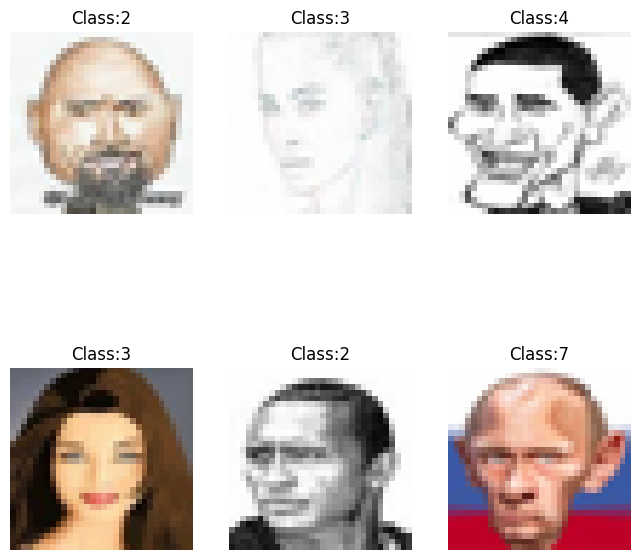

In [235]:
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

ind = np.random.randint(0,y.shape[0],6)
display_images(X[ind,...],y[ind], row=2,col=3)

## Dimensionality Reduction
- Plot eigen spectrum for the data.

Percentage of variance preserved is defined as the fraction of eigen values used. As we include more principal components to describe the data, the percentage of variances preserved under the dimensionality reduction increases. 

- Plot the percentage of variances vs the number of principal components to validate the above statement.
- Try visualizing these eigen vectors. Comment on what these ghost faces represent 
- Try reconstructing images with your choice of number of principal components and visualize the reconstructed image.

Let's define reconstruction error as the frobenius norm of the difference between original and reconstructed image. 

- Plot the number of principal components vs the corresponding reconstruction error for 5 selected number of principal components of your choice.
- Using the two dominant principal values, plot the data with colors showing the labels. What do you observe?


#### Write a function that gives eigen values and eigen vectors given data

In [236]:
X = X.reshape(len(X), -1)

In [237]:
# write function
def compute_eigen_values(X):
    mean_sub = (X - np.mean(X, axis=0))
    AAt = mean_sub.dot(mean_sub.T)
    eigen_values, eigen_vectors = np.linalg.eigh(AAt) # AAt is a symmetric matrix, we can use eigh
    idx = range(len(eigen_values)-1, -1, -1)
    eigen_values = eigen_values[idx]
    eigen_vectors = eigen_vectors[:, idx]
    eigen_faces = mean_sub.T.dot(eigen_vectors)
    return eigen_values, eigen_vectors, eigen_faces
eigen_values, eigen_vectors, eigen_faces = compute_eigen_values(X)

#### Compute eigen values and plot eigen value spectrum

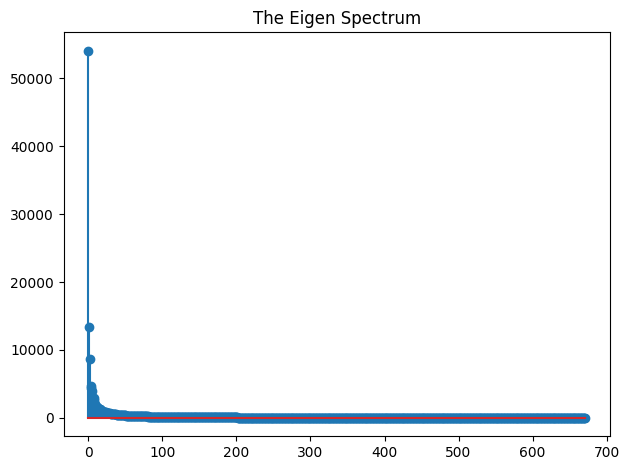

In [238]:
# eigen values and spectrum
plt.stem(range(len(eigen_values)),eigen_values,)
plt.title("The Eigen Spectrum")
plt.tight_layout()
plt.show()

#### Plot the percentage of variances vs the number of principal components

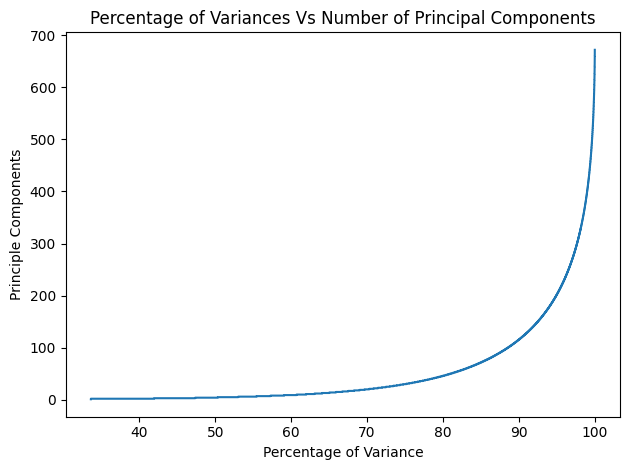

In [239]:
# plot variance vs components
eigen_ratio = (eigen_values/sum(eigen_values))*100
percentage = np.cumsum(eigen_ratio)
plt.step(percentage, range(1, len(percentage)+1))
plt.title("Percentage of Variances Vs Number of Principal Components")
plt.xlabel("Percentage of Variance")
plt.ylabel("Principle Components")
plt.tight_layout()
plt.show()

for i in range(len(percentage)):
    if(percentage[i] >= 90):
        entire_dataset = i
        break

#### Visualize eigen faces(eigen vectors)

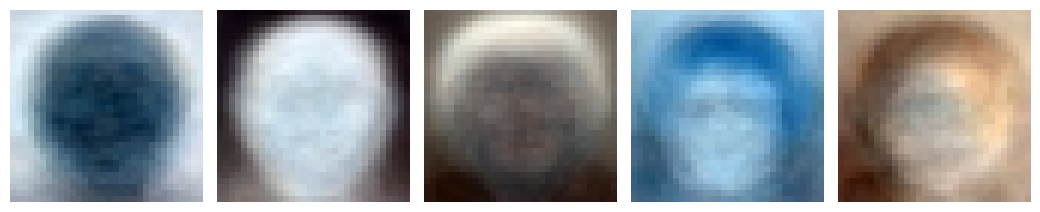

In [240]:
def plot_img(image,H,W,C,indices):
    pl = np.reshape(image,(-1,H,W,C))
    plt.figure(figsize=(25,25))
    for c,i in enumerate(indices):
        ele = pl[i]
        minim = np.min(ele)
        maxim = np.max(ele)
        ele = (ele - minim) / (maxim - minim)
        ele = np.clip(ele,0,254)
        plt.subplot(1,12,c+1)
        plt.axis('off')
        plt.imshow(ele,cmap=plt.cm.gray)
        plt.tight_layout()
    plt.show()

indices = list(range(0, 5))
plot_img(eigen_faces.T,H,W,C, indices)

#### Reconstruction 

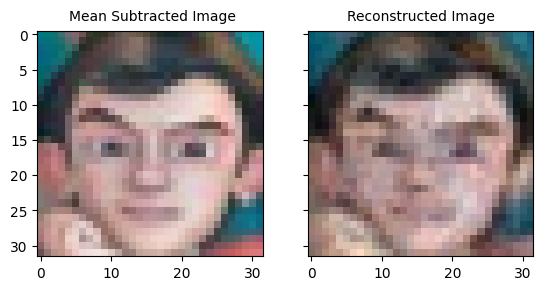

In [241]:
# reconstruction
eigen_faces = eigen_faces.T
for i in range(len(eigen_faces)):
    eigen_faces[i] /= np.linalg.norm(eigen_faces[i])
n_components = 200
mean_face = np.mean(X, axis=0)
mean_sub_img = X - mean_face
test_img = mean_sub_img[4]
plt.show()
temp =eigen_faces[:n_components].dot(test_img)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.text(4, -2, "Mean Subtracted Image")
ax1.imshow((test_img.reshape((32, 32, 3))- np.min(test_img))/(np.max(test_img) - np.min(test_img))) # Normalizing the whole image. Gives a better look of the image. 
reconstruction = eigen_faces[:n_components].T.dot(temp)
ax2.imshow((reconstruction.reshape((32, 32, 3)) - np.min(reconstruction))/(np.max(reconstruction) - np.min(reconstruction)))
ax2.text(5, -2, "Reconstructed Image")
plt.show()


#### Plot data in 2D

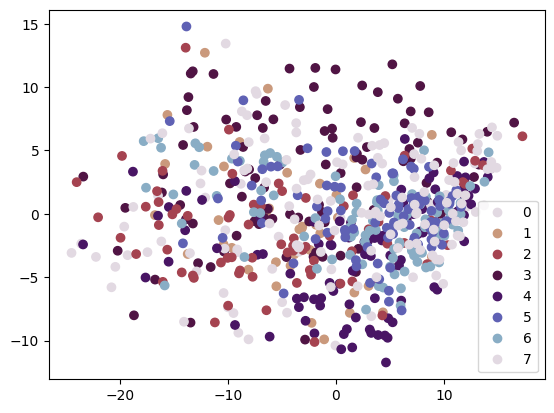

In [242]:
# plot data in 2D
n_components_1 = 2
pca_2 = []
for i in mean_sub_img:
    temp_1  = eigen_faces[:n_components_1].dot(i)
    pca_2 += [temp_1]
pca_2 = np.array(pca_2)
# this is the 2 dimensional data after PCAing the whole data
fig, axes = plt.subplots()
scatter = axes.scatter(pca_2[:, 0], pca_2[:,1], c=y, cmap=plt.cm.twilight_r)
legend_temp = axes.legend(*scatter.legend_elements(), )
plt.show()

## Lets analyze the principal components classwise
- Visualize dominant eigen faces of each of the classes.
- Print the number of principal components required to retain 90% variance for each of the classes and for the entire dataset
- Are the number of components same for entire dataset and each of the classes. If yes why? If not why?

Example output:
```
Number of principal components required for 90% reconstruction of the:
Entire Dataset = 10 
Amitabhbachan = 10
AamirKhan = 10
...
```

In [243]:
# Load data again
X,y = load_data(dirpath)
X = X.reshape(len(X), -1)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)


#### Visualize dominant eigen faces of each of the classes

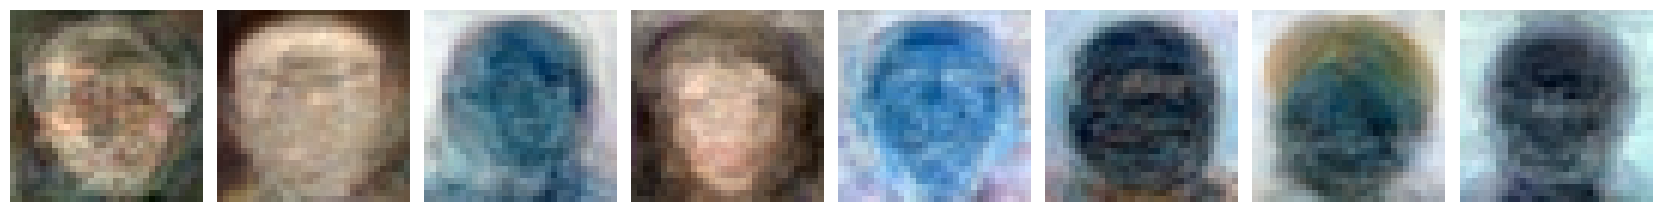

In [244]:
# visualize
dom_faces, eigen_values_1 ,eigen_vectors_1 = [], [], []
for i in range(len(np.unique(y))):
    idx_1 = np.where(y==i)
    X_1 = X[idx_1]
    eig_val_1, eig_vec_1, eig_face_1 = compute_eigen_values(X_1)
    dom_faces += [eig_face_1.T[0]]
    eigen_values_1 += [eig_val_1]
    eigen_vectors_1 += [eig_vec_1]
dom_faces, eigen_values_1, eigen_vectors_1  = np.array(dom_faces), np.array(eigen_values_1), np.array(eigen_vectors_1)
plot_img(dom_faces,H,W,C, list(range(len(dom_faces))))

#### Number of principal components required to retain 90% variance for each of the classes and for the entire dataset

In [256]:
# components required
pc_retained = []
for i in range(len(np.unique(y))):
    eigen_ratio = (eigen_values_1[i]/sum(eigen_values_1[i]))*100
    percentage = np.cumsum(eigen_ratio)
    for j in range(len(percentage)):
        if(percentage[j] >= 90):
            pc_retained += [j]
            break
inv_map = {v: k for k, v in cfw_dict.items()}
df = pd.DataFrame({"Classes": [inv_map[i] for i in range(len(np.unique(y)))]+["Entire Dataset"], "Number of Components to retain 90% variance":pc_retained+[entire_dataset]})
df.set_index("Classes")

,Number of Components to retain 90% variance
Classes,
Amitabhbachan,20
AamirKhan,23
DwayneJohnson,27
AishwaryaRai,35
BarackObama,42
NarendraModi,56
ManmohanSingh,49
VladimirPutin,43
Entire Dataset,114


#### Analysis : Are the number of components same for entire dataset and each of the classes. If yes why? If not why?

Clearly the number of components requireed to retain 90% of the variance is not the same for all the classes. 

In [251]:
# observation/analysis
observation = []
for j in range(len(np.unique(y))):
    temp = []
    for k in range(len(np.unique(y))):
        temp += [(pc_retained[j] == pc_retained[k])]
    observation += [temp]
pd.DataFrame(observation)

,0,1,2,3,4,5,6,7
0,True,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False
3,False,False,False,True,False,False,False,False
4,False,False,False,False,True,False,False,False
5,False,False,False,False,False,True,False,False
6,False,False,False,False,False,False,True,False
7,False,False,False,False,False,False,False,True


## Linear Regression (continued)
1. Perform linear regression on below datapoints
2. Use PCA for dimensionality reduction on this datapoints and then perform Linear regression.
3. Perform this experiment on different number of components and report the score for linear regression. Plot the graph of [1-200] principal components vs regression score. What do you observe?

Note :- Can use inbuilt functions for Linear Regression and PCA for this question

In [247]:
# datapoints
X,_ = load_data(dirpath)
X = X.reshape((X.shape[0],-1))
label = np.array([randrange((32*32*3)) for i in range(5)])
label = np.mean(X[:,label], axis = 1)
print(label.shape)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)
(672,)


In [257]:
pd.DataFrame(label)

,0
0,0.276562
1,0.708594
2,0.475781
3,0.442188
4,0.340625
...,...
667,0.631250
668,0.725000
669,0.741406
670,0.442188


In [258]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
0,0.003906,0.000000,0.000000,0.000000,0.003906,0.003906,0.000000,0.011719,0.015625,0.003906,...,0.386719,0.925781,0.617188,0.371094,0.902344,0.605469,0.332031,0.859375,0.578125,0.277344
1,0.003906,0.000000,0.082031,0.003906,0.000000,0.070312,0.007812,0.000000,0.054688,0.011719,...,0.171875,0.105469,0.093750,0.113281,0.246094,0.218750,0.246094,0.285156,0.246094,0.277344
2,0.976562,0.980469,0.960938,0.980469,0.984375,0.945312,0.976562,0.984375,0.925781,0.996094,...,0.578125,0.789062,0.925781,0.546875,0.753906,0.906250,0.531250,0.644531,0.820312,0.457031
3,0.656250,0.656250,0.687500,0.652344,0.656250,0.683594,0.644531,0.660156,0.675781,0.648438,...,0.437500,0.324219,0.308594,0.445312,0.324219,0.308594,0.445312,0.324219,0.308594,0.445312
4,0.000000,0.546875,0.562500,0.000000,0.542969,0.542969,0.074219,0.503906,0.500000,0.273438,...,0.292969,0.906250,0.410156,0.363281,0.921875,0.449219,0.421875,0.910156,0.453125,0.441406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.570312,0.472656,0.417969,0.292969,0.167969,0.093750,0.351562,0.195312,0.093750,0.492188,...,0.664062,0.917969,0.730469,0.644531,0.886719,0.703125,0.621094,0.804688,0.621094,0.542969
668,0.992188,0.992188,0.996094,0.996094,0.988281,0.996094,0.996094,0.988281,0.996094,0.996094,...,0.812500,0.609375,0.601562,0.546875,0.957031,0.957031,0.917969,0.992188,0.992188,0.972656
669,0.957031,0.742188,0.542969,0.949219,0.746094,0.550781,0.949219,0.750000,0.562500,0.949219,...,0.968750,0.996094,0.984375,0.960938,0.996094,0.992188,0.972656,0.992188,0.996094,0.976562
670,0.964844,0.980469,0.281250,0.972656,0.988281,0.285156,0.968750,0.988281,0.277344,0.968750,...,0.324219,0.960938,0.964844,0.320312,0.992188,0.996094,0.429688,0.503906,0.511719,0.191406


In [275]:
# code here
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize


mse = []
score = []
for i in range(1, 201):
    pca_model = PCA(n_components = i)
    temp = normalize(pca_model.fit_transform(X))
    pd.DataFrame(temp)
    lr_model = LinearRegression()
    x_train, x_test, y_train, y_test = train_test_split(temp, y, test_size=0.3, random_state=42)
    lr_model.fit(x_train, y_train)
    y_pred = lr_model.predict(x_test)
    mse += [(sum((y_pred - y_test)**2))]
    score += [lr_model.score(x_test, y_test)]

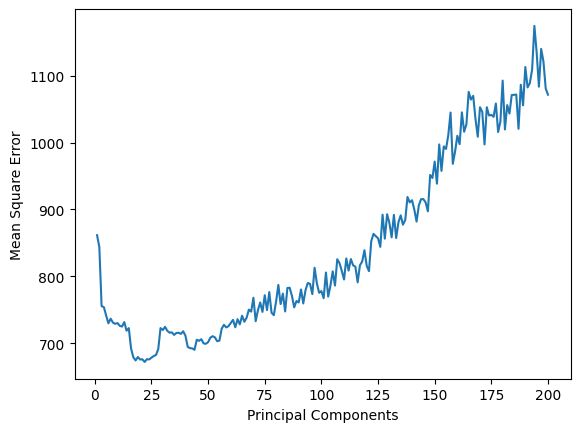

In [279]:
plt.plot(list(range(1, 201)), mse)
plt.ylabel("Mean Square Error")
plt.xlabel("Principal Components")
plt.show()

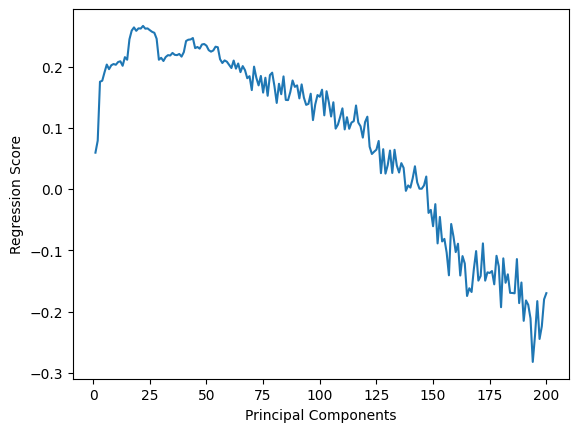

In [280]:
plt.plot(list(range(1, 201)), score)
plt.ylabel("Regression Score")
plt.xlabel("Principal Components")
plt.show()

In [281]:
# analysis / plot (split the cells if required)